In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, Markdown

import pandas as pd
import numpy as np

import json

np.__version__

/var/folders/b7/c67wpzpn25q0h072y9mmz_th0000gn/T/ipykernel_28562/2341679603.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


'1.26.3'

In [2]:
PRIOR_OUTPUT_PATH = './data/17-OUTPUT-gpt4-turbo-redo-love-song-types-with-some-new-types.csv'

last_labeling_pass_with_extra_types = pd.read_csv(PRIOR_OUTPUT_PATH)
last_labeling_pass_with_extra_types

,performer,song,justification,love_song_sub_type
0,"""Weird Al"" Yankovic",White & Nerdy,"a parody about nerd culture and stereotypes, n...",NaN
1,'N Sync,(God Must Have Spent) A Little More Time On You,expressing how special and perfect his love in...,Serenade
2,'N Sync,Bye Bye Bye,a song about breaking up and saying goodbye to...,Good Riddance
3,'N Sync,It's Gonna Be Me,asserts that he will be the one to make the lo...,Courtship & Anticipation
4,'N Sync,This I Promise You,promising to always love someone,Serenade
...,...,...,...,...
5011,matchbox twenty,Unwell,"though the speaker does not feel well, he reas...",Courtship & Anticipation
5012,twenty one pilots,Heathens,"about social outcasts, not romance",NaN
5013,twenty one pilots,Ride,"introspective about life's journey, not focuse...",NaN
5014,twenty one pilots,Stressed Out,reflects on the pressures of adulthood and lon...,NaN


In [3]:
needs_relabel_df = last_labeling_pass_with_extra_types[
    last_labeling_pass_with_extra_types.love_song_sub_type.apply(
        lambda t: t in ['No Thank You', 'Uncategorized Love Song']
    )
]

needs_relabel_df.love_song_sub_type.unique()
needs_relabel_df

,performer,song,justification,love_song_sub_type
9,10cc,I'm Not In Love,"the speaker claims he does not love her, but t...",Uncategorized Love Song
26,3OH!3 Featuring Ke$ha,My First Kiss,"reminiscing about a first kiss, which is a fon...",Uncategorized Love Song
56,ABBA,Waterloo,uses the metaphor of the battle of Waterloo to...,Uncategorized Love Song
60,AWB,Cut The Cake,"seems to be about a celebration, possibly of l...",Uncategorized Love Song
63,Aaliyah,Back & Forth,"a song about going out to party, with a mild f...",Uncategorized Love Song
...,...,...,...,...
4828,U2,Mysterious Ways,touches on the enigmatic nature of a woman and...,Uncategorized Love Song
4948,Will To Power,I'm Not In Love,claims not to be in love but the lyrics indica...,Uncategorized Love Song
4950,William DeVaughn,Be Thankful For What You Got,"gratitude for what one has, including love, al...",Uncategorized Love Song
4964,Wings,Silly Love Songs,"defends the validity and depth of love songs, ...",Uncategorized Love Song


# Setup GPT4 call

In [4]:
import os
import openai
# openai.organization = "personal"
openai.api_key = os.getenv("OPENAI_API_KEY")
[model.id for model in openai.Model.list()['data']]

['gpt-4-0613',
 'curie-search-query',
 'gpt-4',
 'babbage-search-query',
 'dall-e-3',
 'babbage-search-document',
 'dall-e-2',
 'gpt-3.5-turbo-0301',
 'davinci-search-query',
 'gpt-4-1106-preview',
 'tts-1-hd-1106',
 'tts-1-hd',
 'ada-search-document',
 'ada-code-search-code',
 'davinci-002',
 'babbage-002',
 'gpt-4-vision-preview',
 'davinci-search-document',
 'curie-search-document',
 'ada-search-query',
 'ada-code-search-text',
 'text-embedding-ada-002',
 'gpt-3.5-turbo-16k-0613',
 'whisper-1',
 'gpt-3.5-turbo-16k',
 'gpt-3.5-turbo',
 'gpt-3.5-turbo-0613',
 'gpt-3.5-turbo-1106',
 'gpt-3.5-turbo-instruct',
 'gpt-3.5-turbo-instruct-0914',
 'tts-1-1106',
 'tts-1']

In [5]:
LOVE_SONG_LABELING_PROMPT = """
You are an expert pop music critic, able to label pop songs as different kinds of love songs using subtle context, emotions, & relational implications.

For each Billboard Top 10 hit in the form [song, performer] in the larger input array, I want you to respond with a valid JSON array of:

[performer, song, justification, love_song_subtype_label]

The justification is a short snippet explaining why the song best fits in the chosen category.

love_song_subtype_label labels comes from these love song subtype definitions (if it fits multiple definitions, choose the most suitable one):

"Serenade": A song directed at someone the singer loves, expressing their deep affection, undying love, infatuation, or praising someone as a soulmate.

"Sexual Conquest": Songs that are less about the object of affection and more about the singer's own prowess or success in romantic pursuits.

"Love Song for the Self": Songs that express self-love and affirmation, whether for one's character or physical qualities, sometimes following a period of growth or learning from past relationships.

"Good Riddance": typically after a breakup with someone who now seems unsuitable. songs about having had someone's love, but being glad now you've moved on (or realizing you should), often involving self-empowerment, anger, revenge, relief, or bitterness, often because of betrayal or potentially cheating.

"Longing & Heartbreak": songs where you love or miss someone, but they are unable to return your love. Either because you broke up and the relationship is over, or because you were never together and the love was unrequited. COuld be full of regret, longing, frustration, sadness, hopelessness, even grief.

"Courtship & Anticipation": the speaker is courting or seeking someone's romantic or sexual love, but they don't have it yet. The love interest does not yet know the speaker well, but the speaker hopes they will want to get to know them better and or please them the way they want.

"It's Complicated": Songs about complicated relationships, often with conflicting emotions like love, hate, frustration, and desire intermingling, whether light-hearted or profound in tone.

"Platonic Love": Songs about non-romantic yet strong and meaningful relationships, such as friendships or familial bonds.

"NA": song is not a love song at all. This would include any non-love song, but also instrumentals, for example.

Here's an example input:

```json
[
	["'N Sync", "This I Promise You"],
	["John Legend", "All of Me"],
	["Beyonce", "Halo"],
	["T-Pain Featuring Lil Wayne", "Can't Believe It"],
	["Adele", "Someone Like You"],
	["Mariah Carey", "Without You"],
	["Dolly Parton", "Jolene"],
	["Bill Withers", "Ain't No Sunshine"],
	["The Rolling Stones", "Miss You"],
	["Whitney Houston", "I Will Always Love You"],
	["Taylor Swift", "Teardrops on My Guitar"],
	["Lesley Gore", "She's A Fool"],
	["Taylor Swift", "You Belong With Me"],
	["Justin Timberlake", "Suit & Tie"],
	["T-Pain Featuring Mike Jones", "I'm N Luv (Wit A Stripper)"],
	["Rihanna", "Only Girl (In the World)"],
	["Britney Spears", "Hold It Against Me"],
	["T-Pain", "Buy U A Drank (Shawty Snappin')"],
	["2Pac", "Dear Mama"],
	["Saweetie", "Best Friend (feat. Doja Cat)"],
	["James Taylor", "You've Got a Friend"],
	["Bill Withers", "Lean On Me"],
	["Little Mix and Jason Derulo", "Secret Love Song"],
	["Katy Perry", "Hot N Cold"],
	["Pat Benatar", "Love Is a Battlefield"],
	["Lauryn Hill", "Ex-Factor"],
	["24kGoldn", "Mood"],
	["T-Pain", "I'm Sprung"],
	["Kelly Clarkson", "Since U Been Gone"],
	["Blu Cantrell", "Hit 'Em Up Style (Oops!)"],
	["Selena Gomez", "Look at Her Now"],
	["Taylor Swift", "Picture To Burn"],
	["Christina Aguilera", "Fighter"],
	["Jamie Foxx Featuring T-Pain", "Blame It"],
	["6ix9ine Featuring Nicki Minaj & Murda Beatz", "FEFE"],
	["The Beach Boys", "I Get Around"],
	["Robin Thicke ft. Pharrell & T.I.", "Blurred Lines"],
	["112", "Peaches & Cream"],
	["Lady Gaga", "Poker Face"],
	["Ariana Grande", "Thank U, Next"],
	["Lizzo", "Good As Hell"],
	["Christina Aguilera", "Beautiful"],
	["Britney Spears", "Womanizer"],
	["TLC", "No Scrubs"],
	["Meghan Trainor", "NO"],
	["Radiohead", "Creep"],
	["Rick Springfield", "Jessie's Girl"],
	["21 Savage & Metro Boomin", "Runnin"],
	["twenty one pilots", "Heathens"],
	["will.i.am & Britney Spears", "Scream & Shout"]
]
```

Here's the sample corresponding output:

```json
{"output":[["'N Sync","This I Promise You","promising to always love someone","Serenade"],["John Legend","All of Me","praises lover, who's affection makes any struggle worth it, promises to give all of them","Serenade"],["Beyonce","Halo","celebrates the angelic quality of a lover and testifies to the positive changes as a result of this love","Serenade"],["T-Pain Featuring Lil Wayne","Can't Believe It","praises love interest, telling her of all the things he'll do for her","Serenade"],["Adele","Someone Like You","bemoans that a lover has moved on to a happy life with another partner while the speaker struggles to move on","Longing & Heartbreak"],["Mariah Carey","Without You","at the moment of a breakup, she expresses despair over everything she will lose","Longing & Heartbreak"],["Dolly Parton","Jolene","her heart is breaking because she fears her male lover will be easily stolen by another woman","Longing & Heartbreak"],["Bill Withers","Ain't No Sunshine","when a lover is away, he expresses that his world seems to become darker","Longing & Heartbreak"],["The Rolling Stones","Miss You","expresses how deeply he misses the lover, and wishes he didn't have to wait","Longing & Heartbreak"],["Whitney Houston","I Will Always Love You","wishes her now gone lover well, reminisces, will never forget","Longing & Heartbreak"],["Taylor Swift","Teardrops on My Guitar","she's in love with a friend who's in love with someone else, she has to pretend she doesn't love him but secretly she's suffering","Longing & Heartbreak"],["Lesley Gore","She's A Fool","her love is with another woman who doesn't appreciate his virtues, longs to some day be noticed by him","Longing & Heartbreak"],["Taylor Swift","You Belong With Me","she's making an empassioned argument that her love object should be with her instead of who he's currently with","Courtship & Anticipation"],["Justin Timberlake","Suit & Tie","looking forward to a night of dancing with his beloved","Courtship & Anticipation"],["T-Pain Featuring Mike Jones","I'm N Luv (Wit A Stripper)","he has strong romantic and sexual feelings for a stripper who doesn't yet know him personally","Courtship & Anticipation"],["Rihanna","Only Girl (In the World)","telling her new love how she wants him to make her feel","Courtship & Anticipation"],["Britney Spears","Hold It Against Me","she's interested in a stragner and approaches them hoping to see if they might get together","Courtship & Anticipation"],["T-Pain","Buy U A Drank (Shawty Snappin')","he spots a woman at the bar and offers to buy her a drink as a prelude to potentially getting together","Courtship & Anticipation"],["2Pac","Dear Mama","love and appreciation for his mother","Platonic Love"],["Saweetie","Best Friend (feat. Doja Cat)","boasts about a close friend who is succesful and strong","Platonic Love"],["James Taylor","You've Got a Friend","promises a close friend they'll be there thick and thin","Platonic Love"],["Bill Withers","Lean On Me","invites a friend to rely on him when they are struggling, as everyone needs platonic support at times","Platonic Love"],["Little Mix and Jason Derulo","Secret Love Song","the speakers long to be united with their lover in public, but must remain in secret","It's Complicated"],["Katy Perry","Hot N Cold","about navigating a lover who cannot make up their mind and is inconsistent","It's Complicated"],["Pat Benatar","Love Is a Battlefield","the relationship she is in alternates between being loving and painful and she doesn't feel like she can leave","It's Complicated"],["Lauryn Hill","Ex-Factor","she feels trapped in a relationship where she feels she's giving more than she's recieving, but whenever she tries to leave, she can't","It's Complicated"],["24kGoldn","Mood","bemoans why his female love interest is always difficult, moody, and inconsistent","It's Complicated"],["T-Pain","I'm Sprung","knows his love interest doesn't deserve him, yet he can't stay away, he vascilates between feelings of deep love and wanting to get away as fast as possible","It's Complicated"],["Kelly Clarkson","Since U Been Gone","ending a bad relationship leaves her feeling better and more in control","Good Riddance"],["Blu Cantrell","Hit 'Em Up Style (Oops!)","reacts to being cheated on by gleefully spending her ex-lover's money, as an act or revents","Good Riddance"],["Selena Gomez","Look at Her Now","after being cheated on, she has now moved on and is better than ever","Good Riddance"],["Taylor Swift","Picture To Burn","after realizing how self-centered and unsuitable her ex-lover is, she vents about all of his negative qualities","Good Riddance"],["Christina Aguilera","Fighter","she thanks the lover because his abuse actually ended up making her stronger and wiser","Good Riddance"],["Jamie Foxx Featuring T-Pain","Blame It","speaker brags about his sexual power & alure, confident his love interest will want to hook up with him","Sexual Conquest"],["6ix9ine Featuring Nicki Minaj & Murda Beatz","FEFE","about sexual prowess with many sexual references","Sexual Conquest"],["The Beach Boys","I Get Around","brag about constantly seeking out new women and never being rejected","Sexual Conquest"],["Robin Thicke ft. Pharrell & T.I.","Blurred Lines","speaker brags about being about to 'get nasty' with a good girl who he claims wants sex","Sexual Conquest"],["112","Peaches & Cream","about sex & being addicted to a tasty woman","Sexual Conquest"],["Lady Gaga","Poker Face","brags about a male sex partner who does not know she is sleeping with a women as well","Sexual Conquest"],["Ariana Grande","Thank U, Next","brags about being unfased and even improved by past relationships ending, and in fact is now thriving in life","Love Song for the Self"],["Lizzo","Good As Hell","an anthem for leaving behidn negativity or men who don't love you anymore, and instead enjoying who you are with pride","Love Song for the Self"],["Christina Aguilera","Beautiful","an anthem proclaiming ones beauty, even in the face of deragatory words or spiteful ex-lovers","Love Song for the Self"],["Britney Spears","Womanizer","in her prowess, she recognizes a womanizer and rejects his advances","Love Song for the Self"],["TLC","No Scrubs","speakers asserts that they will reject so-called scrubs because she wants a higher quality man","Love Song for the Self"],["Meghan Trainor","NO","an anthem for women to confidently reject unwanted male advances, because the men aren't needed for the women to be in the zone","Love Song for the Self"],["Radiohead","Creep","in contrast to his love interest's angelic nature, he feels ugly and invisible, and hates on himself, which does not fit in Longing & Hearbreak or even Good Riddance","Longing & Heartbreak"],["Rick Springfield","Jessie's Girl","praises his friends lover and expresses he's confused she isn't into him too, and he's jealous: themes to unusual to fit into the given love song subtypes.","It's Complicated"],["21 Savage & Metro Boomin","Runnin","a gangster rap, not romance","NA"],["twenty one pilots","Heathens","about social outcasts, not romance","NA"],["will.i.am & Britney Spears","Scream & Shout","about dancing in the club, with no real elements of romance directed toward a specific love interest","NA"]]}
```

Ok, now generate the output for this input:

"""

In [6]:
import ast

def eval_this_str(s):
    return ast.literal_eval(s)

In [7]:
def get_love_song_labels_for_rows(row_subset_str):
    try: 
        completion = openai.ChatCompletion.create(
          model="gpt-4-1106-preview",
          response_format={'type': "json_object"},
          messages=[
            {"role": "user", "content": LOVE_SONG_LABELING_PROMPT},
            {"role": "user", "content": row_subset_str},
          ]
        )
        response_content = eval_this_str(completion.choices[0].message['content'])['output']
        print(f"Response contains {completion['usage']['completion_tokens']} tokens out of 4096 maximum allowed tokens.")
        return response_content
    except Exception as e:
        print('ERROR FETCHING', e)
        return []

### Setup API call batching code

In [16]:
INCREMENT = 75
def fetch_all_data_in_batches(df, increment=INCREMENT):
    gpt_labeled_result = []
    for i in range(101):
        subset = df[['performer', 'song']][i*increment : (i+1)*increment]

        if len(subset):
            subset_as_json_string = subset.to_json(orient='values')
            print([i*increment, (i+1)*increment])
            print(subset_as_json_string, '\n')
            fetched_and_formatted_res = get_love_song_labels_for_rows(subset_as_json_string)
#             print(fetched_and_formatted_res)
            gpt_labeled_result = [*gpt_labeled_result, *fetched_and_formatted_res]
    return gpt_labeled_result

In [17]:
def get_file_path(postfix):
    return f'./data/22-TEMP-gpt4-re-relabel-love-song-types-{postfix}.csv'

In [18]:
def save_to_temp_csv(gpt_labeled_result, run_num):
    first_label_pass_df = pd.DataFrame(
        gpt_labeled_result, 
        columns=['performer', 'song', 
                 'justification',
                 'love_song_sub_type']
    )
    first_label_pass_df.to_csv(get_file_path(run_num), index=False)

# (run a test call to be sure things look ok)
For 100 rows at once:
For GPT4 turbo: 3min, about 3400 tokens out of 4096 maximum allowed tokens 

In [19]:
%%time
TEST_POSTFIX = 'JUST A TEST, DELETE ME'
save_to_temp_csv(
    fetch_all_data_in_batches(
        needs_relabel_df.iloc[0:2]
    ), 
    TEST_POSTFIX
)

[0, 75]
[["10cc","I'm Not In Love"],["3OH!3 Featuring Ke$ha","My First Kiss"]] 

Response contains 97 tokens out of 4096 maximum allowed tokens.
CPU times: user 71.2 ms, sys: 5.97 ms, total: 77.2 ms
Wall time: 4.17 s


In [20]:
pd.read_csv(get_file_path(TEST_POSTFIX))#.iloc[1].justification

,performer,song,justification,love_song_sub_type
0,10cc,I'm Not In Love,despite the repeated assurances that he's not ...,It's Complicated
1,3OH!3 Featuring Ke$ha,My First Kiss,reminiscing about a first kiss rather than an ...,NaN


# Execute calls (in batched batches in case of failure)

In [21]:
%%time
# for 1-5:

save_to_temp_csv(
    fetch_all_data_in_batches(
        needs_relabel_df.iloc[0:1000]
    ), 
    1
)

[0, 75]
[["10cc","I'm Not In Love"],["3OH!3 Featuring Ke$ha","My First Kiss"],["ABBA","Waterloo"],["AWB","Cut The Cake"],["Aaliyah","Back & Forth"],["Aaron Neville","Everybody Plays The Fool"],["Al Stewart","Year Of The Cat"],["Alannah Myles","Black Velvet"],["Andy Grammer","Honey, I'm Good."],["Andy Williams","Lonely Street"],["Anna Kendrick","Cups (Pitch Perfect's When I'm Gone)"],["Atlanta Rhythm Section","Imaginary Lover"],["Ava Max","Sweet But Psycho"],["B-Rock & The Bizz","My Baby Daddy"],["Barbra Streisand","People"],["Bee Gees","I've Gotta Get A Message To You"],["Bell Biv DeVoe","Poison"],["Bette Midler","The Rose"],["Bill Medley & Jennifer Warnes","(I've Had) The Time Of My Life"],["Billy Joel","Tell Her About It"],["Billy Joel","The River Of Dreams"],["Billy Joel","You May Be Right"],["Blessid Union Of Souls","I Believe"],["Bob Seger","Night Moves"],["Bob Seger & The Silver Bullet Band","Shame On The Moon"],["Brenda Lee","Dum Dum"],["Brenda Lee","Emotions"],["Britney Spears"

Response contains 2496 tokens out of 4096 maximum allowed tokens.
[225, 300]
[["The Monkees","Daydream Believer"],["The Osmonds","One Bad Apple"],["The Partridge Family Starring Shirley Jones Featuring David Cassidy","I Think I Love You"],["The Pointer Sisters","Automatic"],["The Rolling Stones","As Tears Go By"],["The Sandpipers","Guantanamera"],["The Shirelles","Mama Said"],["The Turtles","It Ain't Me Babe"],["The Union Gap Featuring Gary Puckett","Young Girl"],["Thomas Dolby","She Blinded Me With Science"],["Thompson Twins","Lay Your Hands On Me"],["Three Dog Night","An Old Fashioned Love Song"],["Tina Turner","Typical Male"],["Tom Jones","Without Love (There Is Nothing)"],["Tommy Edwards","It's All In The Game"],["Tommy Roe","Everybody"],["Tony Toni Tone","If I Had No Loot"],["Train","Drops Of Jupiter (Tell Me)"],["Truth Hurts Featuring Rakim","Addictive"],["Twista","Overnight Celebrity"],["U2","Desire"],["U2","I Still Haven't Found What I'm Looking For"],["U2","Mysterious Ways"],[

# Stitch it all together for a quick & dirty final version (it's ok if we skipped some songs)

In [24]:
love_song_subtypes_df = pd.concat([
    pd.read_csv(get_file_path(1)),
])
love_song_subtypes_df = love_song_subtypes_df.drop_duplicates(subset=['performer', 'song'])
love_song_subtypes_df

,performer,song,justification,love_song_sub_type
0,10cc,I'm Not In Love,"despite constant affirmations, the speaker den...",It's Complicated
1,3OH!3 Featuring Ke$ha,My First Kiss,"recounts the physical act of a first kiss, foc...",NaN
2,ABBA,Waterloo,depicts one's surrender to love as a moment of...,Serenade
3,AWB,Cut The Cake,uses wedding imagery as metaphor for a desirab...,NaN
4,Aaliyah,Back & Forth,focuses on the youthful experience of going ou...,NaN
...,...,...,...,...
247,U2,Mysterious Ways,celebrates a woman's ability to change a man a...,Serenade
248,Will To Power,I'm Not In Love,"is a denial of being in love, indicating not w...",It's Complicated
249,William DeVaughn,Be Thankful For What You Got,"is about appreciating what one has in life, fo...",NaN
250,Wings,Silly Love Songs,is a tongue-in-cheek response to people who di...,Serenade


### Do some sanity checks

In [25]:
love_song_subtypes_df.love_song_sub_type.value_counts()

Serenade                    55
It's Complicated            40
Longing & Heartbreak        26
Courtship & Anticipation    20
Good Riddance               14
Love Song for the Self      12
Sexual Conquest             11
Platonic Love                7
Name: love_song_sub_type, dtype: int64

In [28]:
love_song_subtypes_df[
    love_song_subtypes_df.love_song_sub_type.isna()
]

,performer,song,justification,love_song_sub_type
1,3OH!3 Featuring Ke$ha,My First Kiss,"recounts the physical act of a first kiss, foc...",NaN
3,AWB,Cut The Cake,uses wedding imagery as metaphor for a desirab...,NaN
4,Aaliyah,Back & Forth,focuses on the youthful experience of going ou...,NaN
7,Alannah Myles,Black Velvet,reminisces about Elvis Presley through the len...,NaN
11,Atlanta Rhythm Section,Imaginary Lover,"discusses finding solace in a fantasy partner,...",NaN
...,...,...,...,...
236,Three Dog Night,An Old Fashioned Love Song,is a meta-song about writing a simple and catc...,NaN
245,U2,Desire,"is about the burning desire for more, be it we...",NaN
246,U2,I Still Haven't Found What I'm Looking For,speaks to a spiritual yearning and search for ...,NaN
249,William DeVaughn,Be Thankful For What You Got,"is about appreciating what one has in life, fo...",NaN


# Merge with existing dataset

In [41]:
last_labeling_pass_with_extra_types.set_index(['performer', 'song'])

justification  \
performer                  song                                                                                                 
"Weird Al" Yankovic        White & Nerdy                                    a parody about nerd culture and stereotypes, n...   
'N Sync                    (God Must Have Spent) A Little More Time On You  expressing how special and perfect his love in...   
                           Bye Bye Bye                                      a song about breaking up and saying goodbye to...   
                           It's Gonna Be Me                                 asserts that he will be the one to make the lo...   
                           This I Promise You                                                promising to always love someone   
...                                                                                                                       ...   
matchbox twenty            Unwell                                           though the speaker does not feel well, he reas...   
twenty one pilots          Heathens                                                        about social outcasts, not romance   
                           Ride                                             introspective about life's journey, not focuse...   
                           Stressed Out                                     reflects on the pressures of adulthood and lon...   
will.i.am & Britney Spears Scream & Shout                                   about dancing in the club, with no real elemen...   

                                                                                  love_song_sub_type  
performer                  song                                                                       
"Weird Al" Yankovic        White & Nerdy                                                         NaN  
'N Sync                    (God Must Have Spent) A Little More Time On You                  Serenade  
                           Bye Bye Bye                                                 Good Riddance  
                           It's Gonna Be Me                                 Courtship & Anticipation  
                           This I Promise You                                               Serenade  
...                                                                                              ...  
matchbox twenty            Unwell                                           Courtship & Anticipation  
twenty one pilots          Heathens                                                              NaN  
                           Ride                                                                  NaN  
                           Stressed Out                                                          NaN  
will.i.am & Britney Spears Scream & Shout                                                        NaN  

[5016 rows x 2 columns]

In [49]:
not_relabeled_df = last_labeling_pass_with_extra_types[
    last_labeling_pass_with_extra_types.love_song_sub_type.apply(
        lambda t: t not in ['No Thank You', 'Uncategorized Love Song']
    )
]
merged_df = pd.concat([love_song_subtypes_df, not_relabeled_df])
assert len(merged_df) == len(pd.concat([love_song_subtypes_df, not_relabeled_df]).drop_duplicates())
merged_df

,performer,song,justification,love_song_sub_type
0,10cc,I'm Not In Love,"despite constant affirmations, the speaker den...",It's Complicated
1,3OH!3 Featuring Ke$ha,My First Kiss,"recounts the physical act of a first kiss, foc...",NaN
2,ABBA,Waterloo,depicts one's surrender to love as a moment of...,Serenade
3,AWB,Cut The Cake,uses wedding imagery as metaphor for a desirab...,NaN
4,Aaliyah,Back & Forth,focuses on the youthful experience of going ou...,NaN
...,...,...,...,...
5011,matchbox twenty,Unwell,"though the speaker does not feel well, he reas...",Courtship & Anticipation
5012,twenty one pilots,Heathens,"about social outcasts, not romance",NaN
5013,twenty one pilots,Ride,"introspective about life's journey, not focuse...",NaN
5014,twenty one pilots,Stressed Out,reflects on the pressures of adulthood and lon...,NaN


<AxesSubplot: >

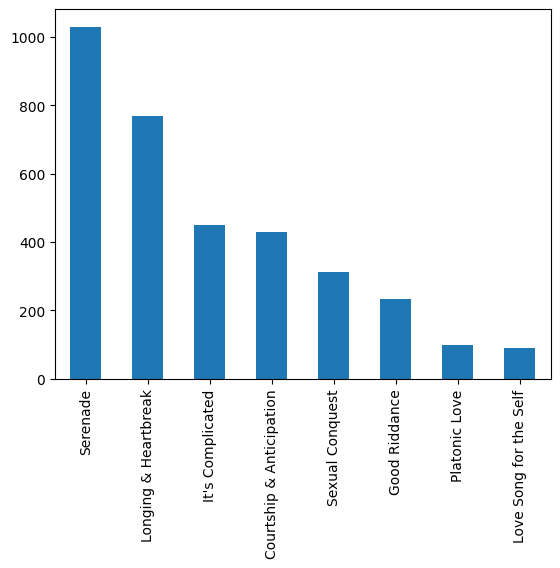

In [52]:
merged_df.love_song_sub_type.value_counts().plot(kind='bar')

# Export

In [53]:
OUTPUT_PATH = './data/22-OUTPUT-gpt4-turbo-redo-uncategorized-and-no-thank-you.csv'
merged_df.to_csv(OUTPUT_PATH, index=False)

In [54]:
pd.read_csv(OUTPUT_PATH)

,performer,song,justification,love_song_sub_type
0,10cc,I'm Not In Love,"despite constant affirmations, the speaker den...",It's Complicated
1,3OH!3 Featuring Ke$ha,My First Kiss,"recounts the physical act of a first kiss, foc...",NaN
2,ABBA,Waterloo,depicts one's surrender to love as a moment of...,Serenade
3,AWB,Cut The Cake,uses wedding imagery as metaphor for a desirab...,NaN
4,Aaliyah,Back & Forth,focuses on the youthful experience of going ou...,NaN
...,...,...,...,...
5011,matchbox twenty,Unwell,"though the speaker does not feel well, he reas...",Courtship & Anticipation
5012,twenty one pilots,Heathens,"about social outcasts, not romance",NaN
5013,twenty one pilots,Ride,"introspective about life's journey, not focuse...",NaN
5014,twenty one pilots,Stressed Out,reflects on the pressures of adulthood and lon...,NaN
